# Ryan Sikhrangkur
# Project: Investigate a Dataset - TMDb Movie Data  


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> This dataset contains information of approximately 10,000 movies collected from The Movie Database (TMDb). Information includes rating, revenue, popularity and more. Important notes from the dataset overview are listed below:
   - Certain columns, like `cast` and `genres`, contain multiple values separated by pipe (|) characters.
   - There are some odd characters in the `cast` column. For this project these characters will be left alone.
   - The final two columns ending with `_adj` show the budget and revenue of the associated movie in terms of 2010 dollars, accounting for inflation over time.


### Question(s) for Analysis
> <strong>1.</strong> What are the most profitable films before and after the 2010 adjustment? Are there certain properties they have in common?

> <strong>2.</strong> Which directors have the highest average popularity? Are the films they've worked on similar or different?

In [1]:
# Import statements for necessary packages.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

In [2]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

Requirement already up-to-date: pandas==0.25.0 in /opt/conda/lib/python3.6/site-packages (0.25.0)


<a id='wrangling'></a>
## Data Wrangling



### General Properties
> Here I will load the dataset using `pandas` and perform a general overview for information such as:
   - Structure of the dataframe. (column detail, order)
   - Dataframe size. (value counts, null counts, duplicate counts)
   - Data types.

In [3]:
# Load the data and print the first few lines.

df_movies = pd.read_csv('tmdb-movies.csv')
df_movies.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [4]:
# Print the size of the dataframe

df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [5]:
# Print the number of duplicate values

df_movies.duplicated().sum()

1

In [6]:
# Aside from null and duplicate values, there could still exist in several columns a value of zero
# where such a value is impossible or unrealistic (budget, revenue). Print the total of nonzero values
# from these columns.

df_movies.query('budget != 0')['budget'].count(), df_movies.query('revenue != 0')['revenue'].count()

(5170, 4850)

In [7]:
# Print the total of nonzero values from the popularity column.

df_movies.query('popularity != 0')['popularity'].count()

10866

In [8]:
# Several columns have a data type of object. By investigating the data type of a specific entry in
# that column, we can see what kind of object it actually stored within the column.

type(df_movies['imdb_id'][0]), type(df_movies['original_title'][0]), type(df_movies['cast'][0])

(str, str, str)

In [9]:
# Print the number of unique genres in the dataset.

df_movies['genres'].nunique()

2039

> From the above four outputs there are several takeaways from this dataset:
   - There are a total of 21 columns and 10,866 rows.
   - Of those 21 columns 9 have null entries, with `homepage` having only 2,936 non-null values.
   - Out of 10,866 entries there is only one duplicate.
   - Less than half the entries have recorded a `budget` and/or `revenue` greater than 0 dollars.
   - The `budget` and `revenue` columns are `dtype: int64` whereas the `budget_adj` and `revenue_adj` columns are `dtype: float64`.
   - All `dtype: object` in the dataset are `str` objects.
   - As noted in the dataset description, columns such as `cast` and `genres` have multiple values separated by the pipe (|) character, but they are saved as a single `str` object.


### Data Cleaning
> With the questions I wish to answer in mind, the steps I will take are as follows:

   <strong>1.</strong> Drop unnecessary and redundant data columns. Columns such as `imdb_id`, `keywords`, and `tagline` are unnecessary for the questions we want answered for our investigation, and it's not necessary we keep both `release_date` and `release_year`.

   <strong>2.</strong> Drop null and duplicate entry values. It's difficult to predict a possible average which could substitute the missing values when working with such a large dataset, and so dropping the entries with null values is more feasible.

   <strong>3.</strong> Drop all entries with a `budget` and/or `revenue` of zero. As addressed above, it would be difficult to estimate the `budget` and `revenue` of films, and it's highly unlikely that a film would report zero `revenue` while reporting a nonzero `popularity`.

   <strong>4.</strong> Change the order of columns for easier legibility. Normally the first information we want to know about a film is the `original_title` and other properties behind the film. Also, `popularity` would make more sense if it were with `vote_count` and `vote_average`, as well as pairing `budget` and `revenue` with `budget_adj` and `revenue_adj`.

   <strong>5.</strong> Change the data types of columns which require direct comparison. Specifically, `budget`, `revenue`, `budget_adj` and `revenue_adj` should be the same data type for consistency.

   <strong>6.</strong> Separate 

In [10]:
# Drop unnecessary and redundant data columns.

df_movies.drop(['imdb_id', 'homepage', 'tagline', 'keywords', 'overview', 'release_date'], axis=1, inplace=True)
df_movies.head()

,id,popularity,budget,revenue,original_title,cast,director,runtime,genres,production_companies,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,2947,7.3,2015,1.747999e+08,1.385749e+09


In [11]:
# Remove all null and duplicate values.

df_movies.dropna(inplace=True)
df_movies.drop_duplicates(inplace=True)
df_movies.info(), df_movies.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9772 entries, 0 to 10865
Data columns (total 15 columns):
id                      9772 non-null int64
popularity              9772 non-null float64
budget                  9772 non-null int64
revenue                 9772 non-null int64
original_title          9772 non-null object
cast                    9772 non-null object
director                9772 non-null object
runtime                 9772 non-null int64
genres                  9772 non-null object
production_companies    9772 non-null object
vote_count              9772 non-null int64
vote_average            9772 non-null float64
release_year            9772 non-null int64
budget_adj              9772 non-null float64
revenue_adj             9772 non-null float64
dtypes: float64(4), int64(6), object(5)
memory usage: 1.2+ MB


(None, 0)

In [12]:
# Drop all entries with a budget or revenue of 0.

df_movies = df_movies[(df_movies[['budget', 'revenue']] != 0).all(axis=1)]
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3805 entries, 0 to 10848
Data columns (total 15 columns):
id                      3805 non-null int64
popularity              3805 non-null float64
budget                  3805 non-null int64
revenue                 3805 non-null int64
original_title          3805 non-null object
cast                    3805 non-null object
director                3805 non-null object
runtime                 3805 non-null int64
genres                  3805 non-null object
production_companies    3805 non-null object
vote_count              3805 non-null int64
vote_average            3805 non-null float64
release_year            3805 non-null int64
budget_adj              3805 non-null float64
revenue_adj             3805 non-null float64
dtypes: float64(4), int64(6), object(5)
memory usage: 475.6+ KB


In [13]:
# Change the order of columns.

df_movies = df_movies[['id', 'original_title', 'production_companies',
                       'director', 'cast', 'genres', 'release_year', 'runtime', 'popularity',
                      'vote_average', 'vote_count', 'budget', 'revenue', 'budget_adj', 'revenue_adj']]
df_movies.head()

,id,original_title,production_companies,director,cast,genres,release_year,runtime,popularity,vote_average,vote_count,budget,revenue,budget_adj,revenue_adj
0,135397,Jurassic World,Universal Studios|Amblin Entertainment|Legenda...,Colin Trevorrow,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Action|Adventure|Science Fiction|Thriller,2015,124,32.985763,6.5,5562,150000000,1513528810,1.379999e+08,1.392446e+09
1,76341,Mad Max: Fury Road,Village Roadshow Pictures|Kennedy Miller Produ...,George Miller,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,Action|Adventure|Science Fiction|Thriller,2015,120,28.419936,7.1,6185,150000000,378436354,1.379999e+08,3.481613e+08
2,262500,Insurgent,Summit Entertainment|Mandeville Films|Red Wago...,Robert Schwentke,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Adventure|Science Fiction|Thriller,2015,119,13.112507,6.3,2480,110000000,295238201,1.012000e+08,2.716190e+08
3,140607,Star Wars: The Force Awakens,Lucasfilm|Truenorth Productions|Bad Robot,J.J. Abrams,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,Action|Adventure|Science Fiction|Fantasy,2015,136,11.173104,7.5,5292,200000000,2068178225,1.839999e+08,1.902723e+09
4,168259,Furious 7,Universal Pictures|Original Film|Media Rights ...,James Wan,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,Action|Crime|Thriller,2015,137,9.335014,7.3,2947,190000000,1506249360,1.747999e+08,1.385749e+09


In [14]:
# Change the data types of the budget and revenue columns

df_movies['budget'] = df_movies['budget'].astype('float')
df_movies['revenue'] = df_movies['revenue'].astype('float')
df_movies.head()

,id,original_title,production_companies,director,cast,genres,release_year,runtime,popularity,vote_average,vote_count,budget,revenue,budget_adj,revenue_adj
0,135397,Jurassic World,Universal Studios|Amblin Entertainment|Legenda...,Colin Trevorrow,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Action|Adventure|Science Fiction|Thriller,2015,124,32.985763,6.5,5562,150000000.0,1.513529e+09,1.379999e+08,1.392446e+09
1,76341,Mad Max: Fury Road,Village Roadshow Pictures|Kennedy Miller Produ...,George Miller,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,Action|Adventure|Science Fiction|Thriller,2015,120,28.419936,7.1,6185,150000000.0,3.784364e+08,1.379999e+08,3.481613e+08
2,262500,Insurgent,Summit Entertainment|Mandeville Films|Red Wago...,Robert Schwentke,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Adventure|Science Fiction|Thriller,2015,119,13.112507,6.3,2480,110000000.0,2.952382e+08,1.012000e+08,2.716190e+08
3,140607,Star Wars: The Force Awakens,Lucasfilm|Truenorth Productions|Bad Robot,J.J. Abrams,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,Action|Adventure|Science Fiction|Fantasy,2015,136,11.173104,7.5,5292,200000000.0,2.068178e+09,1.839999e+08,1.902723e+09
4,168259,Furious 7,Universal Pictures|Original Film|Media Rights ...,James Wan,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,Action|Crime|Thriller,2015,137,9.335014,7.3,2947,190000000.0,1.506249e+09,1.747999e+08,1.385749e+09


In [15]:
# Split the production_companies, cast and genres columns.

df_movies['production_companies'] = df_movies['production_companies'].str.split("|")
df_movies['director'] = df_movies['director'].str.split("|")
df_movies['cast'] = df_movies['cast'].str.split("|")
df_movies['genres'] = df_movies['genres'].str.split("|")
df_movies.head()

,id,original_title,production_companies,director,cast,genres,release_year,runtime,popularity,vote_average,vote_count,budget,revenue,budget_adj,revenue_adj
0,135397,Jurassic World,"[Universal Studios, Amblin Entertainment, Lege...",[Colin Trevorrow],"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...","[Action, Adventure, Science Fiction, Thriller]",2015,124,32.985763,6.5,5562,150000000.0,1.513529e+09,1.379999e+08,1.392446e+09
1,76341,Mad Max: Fury Road,"[Village Roadshow Pictures, Kennedy Miller Pro...",[George Miller],"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...","[Action, Adventure, Science Fiction, Thriller]",2015,120,28.419936,7.1,6185,150000000.0,3.784364e+08,1.379999e+08,3.481613e+08
2,262500,Insurgent,"[Summit Entertainment, Mandeville Films, Red W...",[Robert Schwentke],"[Shailene Woodley, Theo James, Kate Winslet, A...","[Adventure, Science Fiction, Thriller]",2015,119,13.112507,6.3,2480,110000000.0,2.952382e+08,1.012000e+08,2.716190e+08
3,140607,Star Wars: The Force Awakens,"[Lucasfilm, Truenorth Productions, Bad Robot]",[J.J. Abrams],"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...","[Action, Adventure, Science Fiction, Fantasy]",2015,136,11.173104,7.5,5292,200000000.0,2.068178e+09,1.839999e+08,1.902723e+09
4,168259,Furious 7,"[Universal Pictures, Original Film, Media Righ...",[James Wan],"[Vin Diesel, Paul Walker, Jason Statham, Miche...","[Action, Crime, Thriller]",2015,137,9.335014,7.3,2947,190000000.0,1.506249e+09,1.747999e+08,1.385749e+09


In [16]:
# How many unique individual genres are there?

df_movies['genres'].explode().unique(), df_movies['genres'].explode().nunique()

(array(['Action', 'Adventure', 'Science Fiction', 'Thriller', 'Fantasy',
        'Crime', 'Western', 'Drama', 'Family', 'Animation', 'Comedy',
        'Mystery', 'Romance', 'War', 'History', 'Music', 'Horror',
        'Documentary', 'Foreign', 'TV Movie'], dtype=object), 20)

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1: What are the most profitable films before and after the 2010 adjustment? Are there certain properties they have in common?
> I'll answer this question in three steps - first I'll create the two separate datasets based on `release_year`, then look at the other columns (`production_companies`, `cast`, etc.) for any similarities of the films, and finally look at the effect the 2010 adjustment had for both sets.

In [17]:
# The profit of the film is its revenue minus its budget. First make a net_profit and net_profit_adj
# column to better display the values we want.

df_movies['net_profit'] = df_movies['revenue'].sub(df_movies['budget'], axis=0)
df_movies['net_profit_adj'] = df_movies['revenue_adj'].sub(df_movies['budget_adj'], axis=0)
df_movies.head()

,id,original_title,production_companies,director,cast,genres,release_year,runtime,popularity,vote_average,vote_count,budget,revenue,budget_adj,revenue_adj,net_profit,net_profit_adj
0,135397,Jurassic World,"[Universal Studios, Amblin Entertainment, Lege...",[Colin Trevorrow],"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...","[Action, Adventure, Science Fiction, Thriller]",2015,124,32.985763,6.5,5562,150000000.0,1.513529e+09,1.379999e+08,1.392446e+09,1.363529e+09,1.254446e+09
1,76341,Mad Max: Fury Road,"[Village Roadshow Pictures, Kennedy Miller Pro...",[George Miller],"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...","[Action, Adventure, Science Fiction, Thriller]",2015,120,28.419936,7.1,6185,150000000.0,3.784364e+08,1.379999e+08,3.481613e+08,2.284364e+08,2.101614e+08
2,262500,Insurgent,"[Summit Entertainment, Mandeville Films, Red W...",[Robert Schwentke],"[Shailene Woodley, Theo James, Kate Winslet, A...","[Adventure, Science Fiction, Thriller]",2015,119,13.112507,6.3,2480,110000000.0,2.952382e+08,1.012000e+08,2.716190e+08,1.852382e+08,1.704191e+08
3,140607,Star Wars: The Force Awakens,"[Lucasfilm, Truenorth Productions, Bad Robot]",[J.J. Abrams],"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...","[Action, Adventure, Science Fiction, Fantasy]",2015,136,11.173104,7.5,5292,200000000.0,2.068178e+09,1.839999e+08,1.902723e+09,1.868178e+09,1.718723e+09
4,168259,Furious 7,"[Universal Pictures, Original Film, Media Righ...",[James Wan],"[Vin Diesel, Paul Walker, Jason Statham, Miche...","[Action, Crime, Thriller]",2015,137,9.335014,7.3,2947,190000000.0,1.506249e+09,1.747999e+08,1.385749e+09,1.316249e+09,1.210949e+09


In [18]:
# Create two datasets separating movies by release_year.
# release_year < 2010; release_year >= 2010

df_before = df_movies[df_movies['release_year'] < 2010]
before_top = df_before.sort_values('net_profit', ascending=False).head(5)
df_after = df_movies[df_movies['release_year'] >= 2010]
after_top = df_after.sort_values('net_profit', ascending=False).head(5)

In [19]:
# Print the five films of each dataset with the highest net_profit value.

before_top

,id,original_title,production_companies,director,cast,genres,release_year,runtime,popularity,vote_average,vote_count,budget,revenue,budget_adj,revenue_adj,net_profit,net_profit_adj
1386,19995,Avatar,"[Ingenious Film Partners, Twentieth Century Fo...",[James Cameron],"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Action, Adventure, Fantasy, Science Fiction]",2009,162,9.432768,7.1,8458,237000000.0,2.781506e+09,2.408869e+08,2.827124e+09,2.544506e+09,2.586237e+09
5231,597,Titanic,"[Paramount Pictures, Twentieth Century Fox Fil...",[James Cameron],"[Kate Winslet, Leonardo DiCaprio, Frances Fish...","[Drama, Romance, Thriller]",1997,194,4.355219,7.3,4654,200000000.0,1.845034e+09,2.716921e+08,2.506406e+09,1.645034e+09,2.234714e+09
8094,1642,The Net,[Columbia Pictures],[Irwin Winkler],"[Sandra Bullock, Jeremy Northam, Dennis Miller...","[Crime, Drama, Mystery, Thriller, Action]",1995,114,1.136610,5.6,201,22000000.0,1.106280e+09,3.148127e+07,1.583050e+09,1.084280e+09,1.551568e+09
4949,122,The Lord of the Rings: The Return of the King,"[WingNut Films, New Line Cinema]",[Peter Jackson],"[Elijah Wood, Ian McKellen, Viggo Mortensen, L...","[Adventure, Fantasy, Action]",2003,201,7.122455,7.9,5636,94000000.0,1.118889e+09,1.114231e+08,1.326278e+09,1.024889e+09,1.214855e+09
6555,58,Pirates of the Caribbean: Dead Man's Chest,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[Gore Verbinski],"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Adventure, Fantasy, Action]",2006,151,4.205992,6.8,3181,200000000.0,1.065660e+09,2.163338e+08,1.152691e+09,8.656598e+08,9.363575e+08


In [20]:
# Second dataset.

after_top

,id,original_title,production_companies,director,cast,genres,release_year,runtime,popularity,vote_average,vote_count,budget,revenue,budget_adj,revenue_adj,net_profit,net_profit_adj
3,140607,Star Wars: The Force Awakens,"[Lucasfilm, Truenorth Productions, Bad Robot]",[J.J. Abrams],"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...","[Action, Adventure, Science Fiction, Fantasy]",2015,136,11.173104,7.5,5292,200000000.0,2.068178e+09,1.839999e+08,1.902723e+09,1.868178e+09,1.718723e+09
0,135397,Jurassic World,"[Universal Studios, Amblin Entertainment, Lege...",[Colin Trevorrow],"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...","[Action, Adventure, Science Fiction, Thriller]",2015,124,32.985763,6.5,5562,150000000.0,1.513529e+09,1.379999e+08,1.392446e+09,1.363529e+09,1.254446e+09
4,168259,Furious 7,"[Universal Pictures, Original Film, Media Righ...",[James Wan],"[Vin Diesel, Paul Walker, Jason Statham, Miche...","[Action, Crime, Thriller]",2015,137,9.335014,7.3,2947,190000000.0,1.506249e+09,1.747999e+08,1.385749e+09,1.316249e+09,1.210949e+09
4361,24428,The Avengers,[Marvel Studios],[Joss Whedon],"[Robert Downey Jr., Chris Evans, Mark Ruffalo,...","[Science Fiction, Action, Adventure]",2012,143,7.637767,7.3,8903,220000000.0,1.519558e+09,2.089437e+08,1.443191e+09,1.299558e+09,1.234248e+09
3374,12445,Harry Potter and the Deathly Hallows: Part 2,"[Warner Bros., Heyday Films, Moving Picture Co...",[David Yates],"[Daniel Radcliffe, Rupert Grint, Emma Watson, ...","[Adventure, Family, Fantasy]",2011,130,5.711315,7.7,3750,125000000.0,1.327818e+09,1.211748e+08,1.287184e+09,1.202818e+09,1.166009e+09


> Now with the datasets in place, I'll observe their properties for common threads. First, let's look at the genres these films are categorized in.

In [21]:
# How many of each unique genre are in these datasets?
# Print the value_counts of the genres in before_top.

before_top['genres'].explode().value_counts() # 18 total

Action             4
Fantasy            3
Adventure          3
Drama              2
Thriller           2
Science Fiction    1
Mystery            1
Crime              1
Romance            1
Name: genres, dtype: int64

In [22]:
# Print the value_counts of the genres in after_top.

after_top['genres'].explode().value_counts() # 17 total

Adventure          4
Action             4
Science Fiction    3
Fantasy            2
Thriller           2
Family             1
Crime              1
Name: genres, dtype: int64

In [23]:
# Modify the value_counts so we may graph them.

top_genres = sorted(np.unique(np.concatenate((before_top['genres'].explode().unique(), after_top['genres'].explode().unique()), 0)))
before_gcount = before_top['genres'].explode().value_counts()
after_gcount = after_top['genres'].explode().value_counts()

g_index = []
g_value = []
for genre in top_genres :
    if genre not in before_gcount.index :
        g_index.append(genre)
        g_value.append(0)
before_gcount = before_gcount.append(pd.Series(data=g_value, index=g_index)).sort_index(ascending=True)

g_index.clear()
g_value.clear()
for genre in top_genres:
    if genre not in after_gcount.index :
        g_index.append(genre)
        g_value.append(0)
after_gcount = after_gcount.append(pd.Series(data=g_value, index=g_index)).sort_index(ascending=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Series.data is deprecated and will be removed in a future version
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.data is deprecated and will be removed in a future version
  


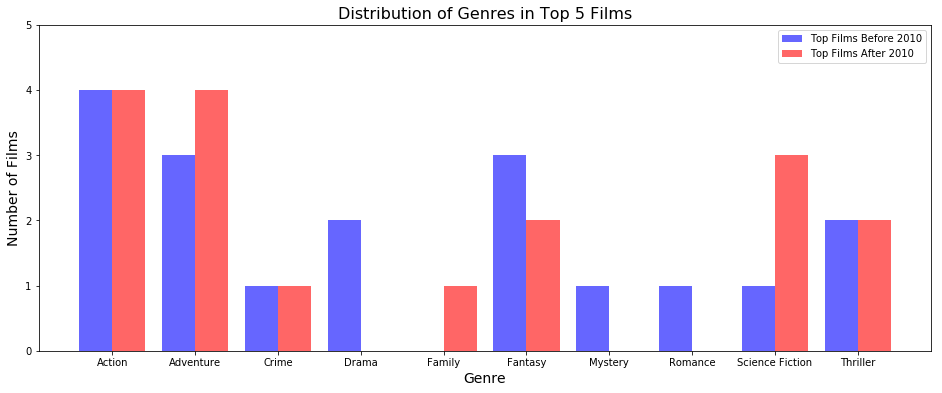

In [24]:
# Build the bar graph.

ind = np.arange(len(top_genres))
width = 0.4
locations = ind+width / 2
plt.figure(figsize=(16,6))
blue_bars = plt.bar(ind, before_gcount.data, width, color='b', alpha=.6, label='Top Films Before 2010')
red_bars = plt.bar(ind+width, after_gcount.data, width, color='r', alpha=.6, label='Top Films After 2010')
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Number of Films', fontsize=14)
plt.xticks(locations, top_genres)
plt.yticks(np.arange(0, 6, 1))
plt.title('Distribution of Genres in Top 5 Films', fontsize=16);
plt.legend();

> Using the above information and graph, there are several observations we can make:
   - Across 5 films, the `before_top` dataset is categorized in 18 genres total and the `after_top` dataset in 17 total, with 13 shared genres. (74.3% similarity)
   - 80% of both datasets are in the `Action` genre.
   - For both datasets, 75% of `Action` films are also in the `Adventure` genre, and the remaining 25% are in the `Thriller` and `Crime` genre.
   - For both datasets, 100% of the films in the `Fantasy` genre are also in the `Adventure` genre.
   - For both datasets, 100% of the films in the `Science Fiction` genre are also in the `Action` and `Adventure` genre.

> After making these observations, we can reasonably assume that the genre and combinations of genres has an effect on the film's success.

With the investigation of these film genres complete, I'll investigate in a similar matter for other elements of the films. The next element will be `runtime`.

In [25]:
# Save the runtime in variables to graph.

before_rt = before_top[['original_title', 'runtime']]
after_rt = after_top[['original_title', 'runtime']]
before_rt

,original_title,runtime
1386,Avatar,162
5231,Titanic,194
8094,The Net,114
4949,The Lord of the Rings: The Return of the King,201
6555,Pirates of the Caribbean: Dead Man's Chest,151


In [26]:
after_rt

,original_title,runtime
3,Star Wars: The Force Awakens,136
0,Jurassic World,124
4,Furious 7,137
4361,The Avengers,143
3374,Harry Potter and the Deathly Hallows: Part 2,130


In [ ]:
# Plot a histogram of the runtimes.

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((before_rt['runtime'], after_rt['runtime'])), bins=25)[1]
plt.hist(before_rt['runtime'], bins, alpha=0.5, label='Top Films Before 2010')
plt.hist(after_rt['runtime'], bins, alpha=0.5, label='Top Films After 2010')
plt.xlabel('Runtime in Minutes', fontsize=14)
plt.ylabel('Number of Films', fontsize=14)
plt.xticks(np.arange(110, 211, 10))
plt.yticks(np.arange(0, 3, 1))
plt.title('Runtime of the Top 5 Films', fontsize=16)
plt.legend();

> Looking at this histogram, the one significant observation we can make is that the most successful films to release after 2010 are condensed into a shorter `runtime` frame between 120 to 150 minutes, whereas the most successful films released before 2010 all have a `runtime` outside this frame.

> Let's finish with looking at the difference in profit for these films when looking at the 2010 adjustment.

In [ ]:
# Obtain the net_profit and net_profit_adj for both movie lists.

before_prof = before_top[['original_title', 'net_profit', 'net_profit_adj']]
before_prof['adj_diff'] = before_prof['net_profit_adj'] - before_prof['net_profit']

before_diff = before_prof[['original_title', 'adj_diff']]
before_diff['adj_diff'] = np.abs(before_diff['adj_diff'])

before_prof

In [ ]:
after_prof = after_top[['original_title', 'net_profit', 'net_profit_adj']]
after_prof['adj_diff'] = after_prof['net_profit_adj'] - after_prof['net_profit']

after_diff = after_prof[['original_title', 'adj_diff']]
after_diff['adj_diff'] = np.abs(after_diff['adj_diff'])

after_prof

In [ ]:
before_titles = before_top['original_title'].tolist()
after_titles = after_top['original_title'].tolist()
x_label = []
for i in range(0, 5) :
    x_label.append(before_titles[i] + ' // ' + after_titles[i])

x_label

In [ ]:
# Make a graph to display the (absolute value) differences.

ind = np.arange(5)
width = 0.4
locations = ind+width / 2
plt.figure(figsize=(16,6))
blue_bars = plt.bar(ind, before_diff['adj_diff'], width, color='b', alpha=.6, label='Top Films Before 2010')
red_bars = plt.bar(ind+width, after_diff['adj_diff'], width, color='r', alpha=.6, label='Top Films After 2010')
plt.xlabel('Films', fontsize=14)
plt.ylabel('Difference in Adjusted Profit (in Hundred Million $)', fontsize=14)
plt.xticks(locations, x_label, rotation=90)
plt.yticks(np.arange(0, 600000001, 50000000))
plt.title('Absolute Difference in Adjusted Profit for the Top 5 Films', fontsize=16);
plt.legend();

> Overall it appears the greater the difference is in time results in a greater adjustment difference.
Additionally, all adjustments for the `after_top` films have a negative impact on their profits, suggesting that the inflation from which the 2010 adjustment is measured from is still in effect or prices are continuing to increase.

> Finally, let's look at what the top 5 films would be of both these lists looking at the `net_profit_adj`.

In [ ]:
top_films = [before_top, after_top]
adj_top = pd.concat(top_films)
adj_top = adj_top.sort_values('net_profit_adj', ascending=False)
adj_top.head(5)

### Research Question 1 Summary
> We have obtained films from the top 5 earnings from both before and after the 2010 inflation adjustment and reviewed a few aspects of them.
   - Both top 5 datasets share 73.4% of the total occurrences of `genres`, with 80% of both datasets being 
    `Action` and the remaining 20% being `Thriller`.
   - No films in the `before_top` dataset have a `runtime` between 120 to 150 minutes, in complete contrast to the films in the `after_top` dataset which all have a `runtime` within that range, suggesting that over 
    time films may have condensed a frame in which viewers are more likely to watch.
   - Comparing the `adj_diff`, that is the `net_profit - net_profit_adj`, of both datasets shows that the adjustment would have a positive growth for the `before_top` films, but a loss for the `after_top` films, suggesting the costs of films is continuing to increase since the 2010 inflation.

### Research Question 2: Which directors have the greatest average popularity? Are the films they've worked on similar or different?

In [ ]:
# Group the films together by director, and find the highest accumulated vote_average among them. Start with the top 10.

df_movies = df_movies.explode('director')
top_directors = df_movies.groupby('director')['popularity'].mean().nlargest(5)
top_directors

In [ ]:
# Separate these directors into their own datasets.

ct_movies = df_movies.query('director == "Colin Trevorrow"')
cs_movies = df_movies.query('director == "Chad Stahelski"')
dl_movies = df_movies.query('director == "David Leitch"')
mt_movies = df_movies.query('director == "Morten Tyldum"')
cn_movies = df_movies.query('director == "Christopher Nolan"')
pop_movies = pd.concat([ct_movies, dl_movies, mt_movies, cn_movies], axis=0)
pop_movies

In [ ]:
ct_movies

In [ ]:
cs_movies

In [ ]:
dl_movies

In [ ]:
mt_movies

In [ ]:
cn_movies

> With the exception of Christopher Nolan, all other directors are credited for two or less films, and two directors are known for the same film. Let's look further in two steps; first any correlation the `popularity` may have with elements such as `vote_count` and `vote_average`.

In [ ]:
# Create a scatterplot for popularity and vote_count.

def set_scatter(column_1, column_2, xticks_range, yticks_range) :
    
    fig = plt.figure(figsize=(16,12))
    plt.scatter(df_movies[column_1], df_movies[column_2])
    plt.xlabel(f'{column_1}', fontsize=14)
    plt.ylabel(f'{column_2}', fontsize=14)
    plt.xticks(xticks_range)
    plt.yticks(yticks_range)
    plt.title(f'Correlation between {column_1} and {column_2}', fontsize=16)
    
    return fig

pop_vcount = set_scatter('popularity', 'vote_count', np.arange(0,36,5), np.arange(0,10001,500))
pop_vcount.show()

# plt.figure(figsize=(16,12))
# plt.scatter(df_movies['popularity'], df_movies['vote_count'])
# plt.xlabel('Popularity', fontsize=14)
# plt.ylabel('Vote Count', fontsize=14)
# plt.xticks(np.arange(0, 36, 5))
# plt.yticks(np.arange(0, 10001, 500))
# plt.title('Correlation between Film Popularity and Vote Count', fontsize=16);

In [ ]:
# Create a scatterplot for popularity and vote_average.

pop_vavg = set_scatter('popularity', 'vote_average', np.arange(0,36,5), np.arange(2.0,8.6,0.5))
pop_vavg.show()

# plt.figure(figsize=(16,12))
# plt.scatter(df_movies['popularity'], df_movies['vote_average'])
# plt.xlabel('Popularity', fontsize=14)
# plt.ylabel('Vote Average', fontsize=14)
# plt.xticks(np.arange(0, 36, 5))
# plt.yticks(np.arange(2.0, 8.6, 0.5))
# plt.title('Correlation between Film Popularity and Vote Average', fontsize=16);

> From these two plots we can say there is a moderately positive correlation between `popularity` and `vote_count`, and no correlation between `popularity` and `vote_average`.

> Now let's look at the directors and their work, and see if there are any trends to be found.

In [ ]:
# First we'll look at the production_companies of each list accumulated and then individually in value_count() lists.
# Print a list for production_companies for all five directors.

pop_movies.production_companies.explode().value_counts()

In [ ]:
# Print a list for production_companies in Colin Trevorrow films.

ct_movies.production_companies.explode().value_counts()

> Because we know Colin Trevorrow is credited with only two films, one occurence of each production company tells us that every production company is involved in 50% of the films.

> The next three directors are only credited for one film, and Chat Stahelski and David Leitch are credited for co-directing the same film (John Wick), needless to say each production company involved is responsible for 100% of their films.

In [ ]:
# Print a list for production_companies in Chad Stahelski films.

cs_movies.production_companies.explode().value_counts()

In [ ]:
# Print a list for production_companies in David Leitch films.

dl_movies.production_companies.explode().value_counts()

In [ ]:
# Print a list for production_companies in Morten Tyldum films.

mt_movies.production_companies.explode().value_counts()

In [ ]:
# Display the number of films each production company is credited for directed by Christopher Nolan. Use a bar graph since he's
# credited for more films.

cn_companies = cn_movies.production_companies.explode().value_counts()
ind = np.arange(len(cn_companies))
width = 0.5
locations = ind
plt.figure(figsize=(12,6))
plt.bar(ind, cn_companies, width, alpha=.6)
plt.xlabel('Production Company', fontsize=14)
plt.ylabel('Number of Films', fontsize=14)
plt.xticks(locations, cn_companies.index, rotation=90)
plt.yticks(np.arange(0, 9, 1))
plt.title('Production Companies Credited for Christopher Nolan Films', fontsize=16);

> Christopher Nolan is credited for 8 films, so let's investigate further.

In [ ]:
# Which production companies are credited for each film? This will grant us a better idea of any companies that tend to work
# on the same films.

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
cn_movies['production_companies']

In [ ]:
# What's the percentage of films each production company is credited for?

pct = []
for company in cn_companies :
    pct.append(company/cn_movies.id.count())

company_pct = pd.Series(pct, index=cn_companies.index)
company_pct

> Between these five directors there are 12 unique films(two for Colin Trevorrow, one co-directed by Chad Stahelski and David Leitch, one for Morten Tyldum and eight for Christopher Nolan). In this, we can make one observation of `production_companies` regarding all films:
   - Syncopy, Legendary Pictures and Warner Bros. are credited for 50% of films across all five directors (6/12).

> Because Christopher Nolan is credited for two-thirds of the films, we can refer several other observations:
   - For Christopher Nolan, Syncopy is credited for 75% (6/8) of his films and Legendary Pictures and Warner Bros. are credited for 62.5% (5/8).
   - 100% of `production_companies` credited for more than one film, and Lynda Obst Productions, were credited for films which also credited Syncopy.
   - Warner Bros. and Legendary Pictures are credited for the same five films.
   - DC Comics and DC Entertainment are credited for two films each of the same trilogy (Batman Begins, The Dark Knight, The Dark Knight Rises), but both are credited for only the first film.

In [ ]:
# Let's look at the cast these directors worked with.

pop_movies.cast.explode().value_counts()

In [ ]:
# Print a list of the casts credited for Colin Trevorrow's films.

ct_movies['cast'].explode().value_counts()

In [ ]:
# Print a list of the cast credited for Chad Stahelski's and David Leitch's film.

dl_movies['cast'].explode().value_counts()

In [ ]:
# Print a list of the cast credited for Morten Tyldum's film.

mt_movies['cast'].explode().value_counts()

In [ ]:
# Display a graph of the casts credited for Christopher Nolan's films.

cn_cast = cn_movies['cast'].explode().value_counts()
ind = np.arange(len(cn_cast))
width = 0.5
locations = ind
plt.figure(figsize=(12,6))
plt.bar(ind, cn_cast, width, alpha=.6)
plt.xlabel('Cast', fontsize=14)
plt.ylabel('Number of Films', fontsize=14)
plt.xticks(locations, cn_cast.index, rotation=90)
plt.yticks(np.arange(0, 9, 1))
plt.title('Cast Credited for Christopher Nolan Films', fontsize=16);

> Compared to `production_companies`, the `cast` is more diverse with the films they've worked on.
   - Michael Caine was credited for the most films. (5/12)
   - All `cast` who have been credited for more than one film were credited for films directed by Christopher Nolan.

In [ ]:
# Finally, let's look into the film genres.

pop_movies.genres.explode().value_counts()

In [ ]:
# Print the genres of Colin Trevorrow's films.

ct_movies.genres.explode().value_counts()

In [ ]:
# Print the genres of Chad Stahelski's and David Leitch's film.

dl_movies.genres.explode().value_counts()

In [ ]:
# Print the genres of Morten Tyldum's film.

mt_movies.genres.explode().value_counts()

In [ ]:
# print the genres of Christopher Nolan's films.

cn_movies.genres.explode().value_counts()

> The `genres` category of course is much more confined than both `production_companies` and `cast`. To note:
   - The Thriller genre is the most popular of these films (75%), followed by Drama (58.3%) and Action (50%).
       - Every director of this list has at least one film in the Thriller genre, at least 50% of the films they're credited for.
   - Christopher Nolan's films reflect the three most popular genres across all five directors and are within 5%.
       - 80% of his films are in the Thriller genre, Drama is 62.5% and Action is 50%.

### Research Question 2 Summary
> Overall it seems `popularity` has a moderately positive correlation with `vote_count`, but little to no correlation with `vote_average`.

> `production_companies` don't seem to have any relation to a film's popularity as much as they do with the `director`, such as the case with Christopher Nolan and Syncopy.

> `cast` is very diverse and is mostly credited for no more than one film, with some exception (Michael Caine, Christian Bale and Gary Oldman are credited for a trilogy and are reprising roles).

> `genres` show heavy favorability with 75% of the films crediting the most popular `director`s being Thriller.

<a id='conclusions'></a>
## Conclusions
The two questions of the ten most profitable films (5 before 2010, 5 after) and five most popular directors of this dataset allowed us to infer several points:
> The film industry has seemingly never recovered from the 2010 inflation which the `revenue_adj` and `budget_adj` are based on, as demonstrated with the observation made on the comparisons made with the `net_profit_adj` field we created.

> The `runtime` of films has condensed over time, suggesting that there is a method as to why; such as mitigating costs, or increased likelihood of sales.

> Certain `genres` seem to be more successful and/or popular than others as suggested in both questions. However, the most popular genres among the two questions are somewhat reversed.
   - Action was twice as popular as Thriller for the most profitable films, but for the most popular directors Thriller was 25% more popular than Action.
   - Action is the most popular genre among both questions, counting for 80% of the first and 50% of the second.

> There appears to be a moderately positive correlation between `popularity` and `vote_count`, and no correlation between `popularity` and `vote_average`.

> The most popular `directors` are most diverse in the `cast` of their films then the `production_companies`.

### Limitations
> Five to ten films per question is a very small sample size for a dataset of nearly 4,000.

> It's difficult to display percentages when using `explode()` to display accumulated data fields due to the sum exceeding the number of films in the sample.

## Submitting your Project 

> This project has been prepared for submission using the cell below.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])